<a href="https://colab.research.google.com/github/stmcwill/BOBmergers/blob/master/bob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy
from scipy.spatial import cKDTree
from scipy import interpolate
import matplotlib.pyplot as plt

i = complex(0,1)

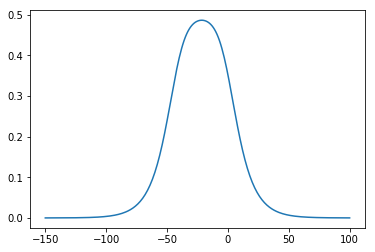

indexleft 123
Aph 0.48632837712279486
indexright 4


TypeError: ignored

In [ ]:
def bob(af, Mf, tp, phip, dt, tmax):
    
    # SYNTAX: [t,h] = bob(af,Mf,tp,phip,dt)
    # Computes the l = m = 2 mode strain for times t > tp using BOB^(TM)
    #   Input:
    #     af   -> final dimensionless spin of merged remnant
    #     Mf   -> final mass of merged remnant, assuming ADM mass M = 1
    #     tp   -> desired time of peak strain, in units of Mf (defaults to 0)
    #     phip -> desired polarization phase, atan(hx/h+), at t = tp (defaults to 0)
    #     dt   -> desired sampling cadence of output, in units of Mf (defaults to 1)
    #     tmax -> desired amount of time after peak, in units of Mf (defaults to 100) 
    #   Output:
    #     t    -> output time array
    #     h    -> output complex strain, h = h+ + i*hx
    #
    
    #Physical parameters
    Mhalf = 1 - (1 - Mf) / 2                    #mass after half of the total energy that will be emitted in GWs is gone, roughly appropriate for normalizing the peak strain

    #Time alignment parameters
    pct = 0.99                    #fractional amplitude to be used for peak finding, i.e. all amplitude data > pct*Apeak is fit to a parabola to find the interpolated peak
    tmin = -150                    #time range for psi4, NOT h. psi4 will peak at t=0, h will ultimately be shifted to peak at t=tp
    t = np.arange(tmin,tmax+dt,dt)          #array of times, ranges from tmin to tmax in steps of dt

   #reference frequencies, capital letters for orbital quantities, lowercase for GW quantities
    Omisco = (-0.091933 * af + 0.097593) / (af ** 2 - 2.4228 * af + 1.4366)                    #my fit, good to O(0.1%) for af < 0.99
    omqnm = 1.5251 - 1.1568 * (1 - af) ** 0.1292                    #Berti fit, from gr-qc/0512160
    omqnm = omqnm / Mf
    Omqnm = omqnm / 2                    #orbital frequency for null perturbation sourcing the l=m=2 QNM
    Q = 0.7 + 1.4187 * (1 - af) ** (-0.499)                    #Berti fit, from gr-qc/0512160
    tau = Q / omqnm
    Tau = 2 * tau                    #orbital Lyapunov-based e-folding time for amplitude of l=m=2

    #Amplitude
    Ap = 1.068 * (1 - Mf) ** 0.8918           #my fit to SXS sims, good to O(1%) for all cases with NR errors that small
    A = Ap / np.cosh(t / Tau)                    #psi4 amplitude, will peak at t=0

    #Orbital frequency, see BOB paper for derivation
    Omref = Omisco * (1 - af)                    #lim(t -> -Inf) Omega, generally 0 <= Omref <= Omisco, this choice empirically works best at early times
    #NB: the choice of Omref has essentially no effect near, at, or after the
    #psi4 peak, it only affects things ~10M before the peak or earlier, but
    #since tp_strain < tp_psi4, this choice will affect the strain peak frequency by a few %
    Omp = ((Omqnm ** 4 + Omref ** 4) / 2) ** (1 / 4)
    Omm = ((Omqnm ** 4 - Omref ** 4) / 2) ** (1 / 4)
    Om = (Omp ** 4 + Omm ** 4 * np.tanh(t / Tau)) ** (1 / 4)
    #NB: if Omref = 0, then Om = Omqnm*((1 + tanh(t/Tau))/2)^(1/4);

    #Orbital phase, see BOB paper for derivation
    kappap = (Omp ** 4 - Omm ** 4) ** (1 / 4)
    kappam = (Omp ** 4 + Omm ** 4) ** (1 / 4)
    z1 = Om/kappam+0j
    z2 = Omp/kappam+0j
    z3 = Om/kappap+0j
    z4 = Omp/kappap+0j
    Phi = Tau * ((np.arctan(Om / kappam) - np.arctan(Omp / kappam)) * kappam + (np.arctanh(z1) - np.arctanh(z2)) * kappam - (np.arctan(Om / kappap) - np.arctan(Omp / kappap)) * kappap - (np.arctanh(z3) - np.arctanh(z4)) * kappap)

    #GW frequency and phase from orbital values
    om = 2 * Om
    phi = 2 * Phi

    #complex psi4, psi4 = psi4_+ + i*psi4_x
    psi4 = A * np.exp(i*phi)

    #complex strain, h = h_+ + i*h_x. For quasicircular motion, psi4 ~ -omega^2*h
    h = -((Mhalf / Mf) ** 2) * om ** (-2) * psi4                    #NB: if ~half the energy is radiated before the peak, this mass normalization makes the most sense
    Ah = abs(h)                    #assuming quasicircularity, only strain amplitude and psi4 amplitude differ, not phases
    phih = np.unwrap(np.angle(h))                    #at this point, phih = phipsi4, but we then shift phih to be zero at the strain peak
    
    plt.plot(t,Ah)
    plt.show()
    #calculating time, amplitude, and frequency of peak strain, shifting peak to t=tp
    #the next 6 lines find the peak strain array value Aph, then fits a parabola to all
    #values > pct*Aph, then uses that fit to find the interpolated "true" peak strain
    Aph = max(Ah)
    ind = Ah.tolist().index(Aph)
    
    distance_left, indexleft = cKDTree(np.c_[Ah[0:ind].ravel()]).query([pct * Aph], k=1)   
    print("indexleft", indexleft)

###################################################    
    print("Aph", Aph)
    #print("Ah", Ah[0:ind])
    #print("Ah[0:ind]", Ah[0:ind])
    #print("np.c_[Ah[0:ind].ravel()]", np.c_[Ah[0:ind].ravel()])
###################################################
    
    if ind+1 < len(Ah):
        distance_right, indexright = cKDTree(np.c_[Ah[(ind + 1):].ravel()]).query([pct * Aph], k=1)
    else:
        indexright = len(Ah) -1
        print("len - 1 has been used")
    print("indexright", indexright)
    
    pcoeff = np.polyfit(t[indexleft:indexright], Ah[indexleft:indexright], 2)        
    mu1 = np.mean(pcoeff)
    mu2 = np.std(pcoeff)
    tph = mu1 - mu2 * pcoeff[1] / 2 / pcoeff[0]                    #"true" peak time from fit
    phih = phih - scipy.interpolate.spline(t, phih, tph) + phip #making the phase=phip at the interpolated peak time
    #this strain has phase=0 at the strain peak
    t = t - tph + tp                    #this shifts the time so that the peak occurs at tp, specified above
    #NB: since all times are based on omqnm, which was normalized by Mf, and
    #the peak strain fit Ap already accounts for Mf normalization, t and h are
    #already appropriately normalized by Mf
    
    #truncating all data before the peak and after tmax. Note that t(1) will NOT be exactly zero,
    #because the "true" peak occurred between data points and was interpolated.
    #You can interpolate before you truncate if you really need t(1)=0.
    distance_istart, istart = cKDTree(np.c_[t]).query([tp], k=1)
    distance_istop, istop = cKDTree(np.c_[t]).query([tmax + tp], k=1)

###################################################
    print("istart = ", istart)
    print("istop = ", istop)
    print("distance_istart = ", distance_istart)
    print("distance_istop = ", distance_istop)
    print("istart = ", istart)
    print("istop = ", istop)
    print("t[indexleft:indexright] = ", t[indexleft:indexright])
    print("Ah[indexleft:indexright] = ", Ah[indexleft:indexright])
###################################################
    
    t = np.arange(istart,istop)
    h = (istart,istop)

    print("h = ", h)
    print("t = ", t)
    
    return t, h
  
bob(0.69,0.95,0,0,1,100)

In [ ]:
import math
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
#import bob

#The BOB model needs the final mass, Mf, and the final spin, af, of the final merger remnant as inputs.
#You can generate this however you want, but below, I use an NR fit to the
#end-state that depends on the original binary parameters for aligned spins.

#Original binary parameters
q = 1
a1 = 0
a2 = 0

#then the AEI fits (0712.3541,0904.2577,0907.0462) do the rest
eta = q / (1 + q) ** 2 #symmetric mass ratio
atilde = (q ** 2 * a1 + a2) / (q ** 2 + 1)
p0 = 0.04826
p1 = 0.01559
p2 = 0.00485
Mf = 1 - p0 - p1 * (a1 + a2) - p2 * (a1 + a2) ** 2
s4 = -0.1229
s5 = 0.4537
t0 = -2.8904
t2 = -3.5171
t3 = 2.5763
af = atilde + s4 * eta * atilde ** 2 + s5 * eta ** 2 * atilde + t0 * eta * atilde + 2 * math.sqrt(3) * eta + t2 * eta ** 2 + t3 * eta ** 3

#to see the syntax including other options for this function, type "help bob"
#[t, h] = bob(af, Mf)

plt.plot(t,h)
plt.show()

#Make a pretty plot, obviously optional
#font = mstring('Arial')
#fontsize = 30
#linewidth = 3
#figure(1)
#plot(t, real(h), mstring('LineWidth'), linewidth)
#hold(mstring('all'))
#plot(t, imag(h), mstring('LineWidth'), linewidth)
#xlim(mcat([0, 100]))
#xlabel(mstring('$t/M$'), mstring('FontSize'), fontsize, mstring('Interpreter'), mstring('latex'))
#ylabel(mstring('$rh_{22}/M$'), mstring('FontSize'), fontsize, mstring('Interpreter'), mstring('latex'))
#set(gca, mstring('FontSize'), fontsize, mstring('LineWidth'), linewidth)
#legend(mcellarray([mstring('$r\\Re(h_{22})/M$'), mstring('$r\\Im(h_{22})/M$')]), mstring('FontSize'), fontsize, mstring('Interpreter'), mstring('latex'))

NameError: name 't' is not defined

In [ ]:
array  = [1,2,3,4,5]

distance_right, indexright = cKDTree(array).query([2], k=1)


ValueError: Buffer has wrong number of dimensions (expected 2, got 1)